# Exploration of RFI Algorithms

In this memo, we explore the RFI algorithms present in `edges-cal.xrfi` using some real data. The intent is that this memo will be evolving as new RFI algorithms are added, or new features. 

The data we use is from day 76 of 2020. The data is calibrated using the calibration observation from November 2019. We are not so concerned about the calibration accuracy here, or the performance of the data itself -- we just need a set of data with RFI in it to extract.

First import the libraries we need:

In [19]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

from edges_analysis.analysis import Level1, tools
from edges_cal import xrfi
from edges_cal.modelling import ModelFit
import numpy as np

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Reading and Exploration

Now read the data (it has been pre-calibrated using `edges-analysis calibrate`). No RFI flagging was performed on the raw spectra in Level1, so that we can test our xRFI routines from scratch:

In [3]:
data = Level1("/data5/edges/data/steven-level-cache/level1/deb0bda3870d13dba0348fa7c2c3f26f/2020_076_01_10_48.h5")

We make a plot of the input raw spectra, averaged over time:

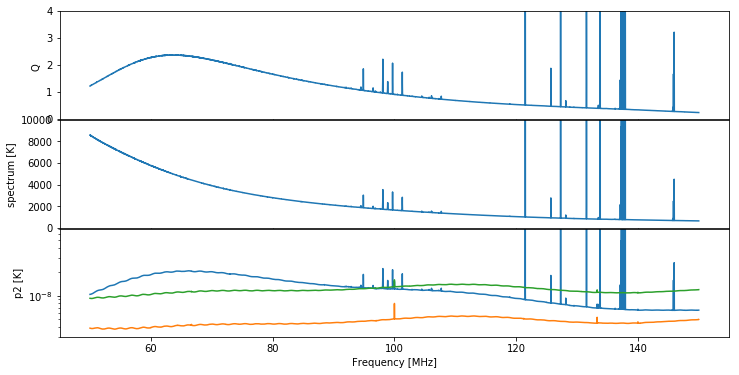

In [6]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 6), gridspec_kw={"hspace":0.01})
data.plot_time_averaged_spectrum('Q', logy=False, ax=ax[0])
ax[0].set_ylim(0, 4)
data.plot_time_averaged_spectrum('spectrum', logy=False, ax=ax[1])
ax[1].set_ylim(0, 10000)
data.plot_time_averaged_spectrum('p0', ax=ax[2])
data.plot_time_averaged_spectrum('p1', ax=ax[2])
data.plot_time_averaged_spectrum('p2', ax=ax[2])
ax[2].set_ylim(3e-9, 7e-8);

In [7]:
print(f"The number of integrations in the file is {data.spectrum.shape[0]}.")

The number of integrations in the file is 91


Let's also show a plot of the unitless power-ratio, $Q$ (we choose $Q$ rather than $T^*$ here because it has lower dynamic range, making it easier to see RFI spikes):

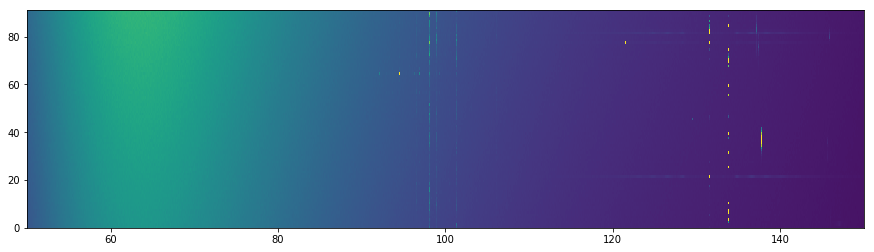

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.imshow(
    data.spectra['Q'], 
    aspect='auto', 
    extent=(data.raw_frequencies.min(), data.raw_frequencies.max(), 0, data.spectrum.shape[0]), 
    vmin=0, vmax=4
);

It's clear that some of the RFI is conregating on certain channels, while other is more time-based.

## Perform xRFI

In [11]:
l1_spectrum = data.spectrum.copy()
l1_flags = data.weights <= 0

### Using Median Filter

In [125]:
medfilt_flag_list = []
medfilt_info_list = []
medfilt_times = []

medfilt_optnames = ['kt', 'kf', 'use_meanfilt', 'max_iter', 'threshold']
medfilt_options = [
    (0, 15, True, 1, 5),    # Don't use time info
    (15, 15, True, 1, 5),   # Default
    (30, 15, True, 1, 5),   # Use more time
    (15, 3, True,1, 5),     # Small frequency window
    (15, 100, True, 1, 5),  # Large frequency window
    (15, 15, False, 1, 5),  # Don't use a mean_filter
    (15, 15, True, 20, 5),  # Let it iterate
    (15, 15, True, 1, 3),   # Lower the threshold
    (15, 15, True, 1, 10),  # Increase the threshold
    (15, 1000, True, 1, 5), # Very wide frequency window
]

for opts in medfilt_options:
    print(f"Computing {opts}...")
    t = time.time()
    flags, info = xrfi.xrfi_medfilt(
        spectrum=l1_spectrum,
        **dict(zip(medfilt_optnames, opts))
    )
    
    # Ensure nothing janky happened to the spectrum
    assert np.all(l1_spectrum == l1.spectrum)
    
    medfilt_flag_list.append(flags)
    medfilt_info_list.append(info)
    
    medfilt_times.append(time.time() - t)

Computing (15, 1000, True, 1, 5)...


Let's look at the flags that each filter obtained:

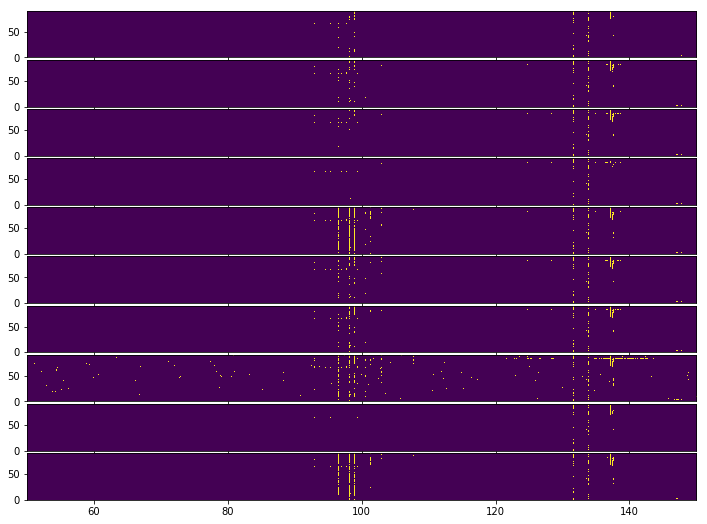

In [127]:
fig, ax = plt.subplots(len(medfilt_flag_list), 1, sharex=True, sharey=True, figsize=(12, 9), gridspec_kw={'hspace':0.05})
for i, fl in enumerate(medfilt_flag_list):
    ax[i].imshow(fl, aspect='auto', extent=(l1.raw_frequencies.min(), l1.raw_frequencies.max(), 0, len(l1_spectrum)));

It is slightly difficult to match up each flag template with the spectrum itself. At a glance, only the wider-frequency windows are able to properly catch the thickly-clustered RFI around 100 MHz. None of the methods are well-able to catch the bright RFI around 140 MHz that happens in the middle of the integrations, though lowering the threshold seems to help.

To have a closer look, we fit a polynomial to one of the time-averaged flagged spectra, and plot each residual (including no xRFI):

In [128]:
spec0 = tools.weighted_mean(l1_spectrum, weights=~medfilt_flag_list[0], axis=0)[0]
mdl = ModelFit('polynomial', l1.raw_frequencies, spec0, n_terms=10).evaluate()

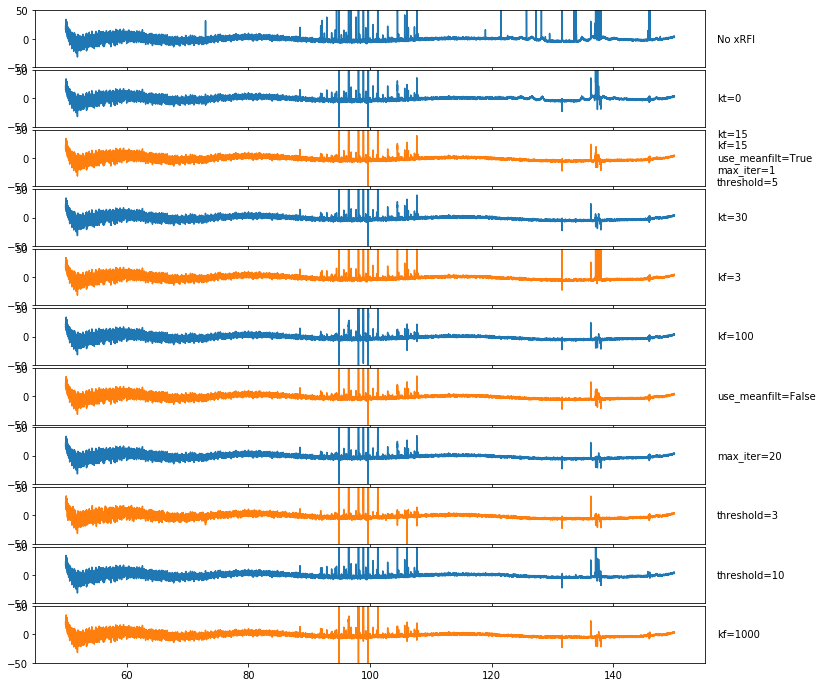

In [129]:
fig, ax = plt.subplots(len(medfilt_flag_list)+1, 1, sharex=True, sharey=True, figsize=(12, 12), gridspec_kw={"hspace":0.05})

ax[0].plot(l1.raw_frequencies, np.mean(l1_spectrum, axis=0)-mdl)
ax[0].text(157, 0, "No xRFI", va='center', ha='left')

for i, (fl, opts) in enumerate(zip(medfilt_flag_list, medfilt_options)):
    spec = tools.weighted_mean(l1_spectrum, ~fl, axis=0)[0]
    ax[i+1].plot(l1.raw_frequencies, spec - mdl, color=f'C{i%2}')
    ax[i+1].set_ylim(-50, 50)
    ax[i+1].text(157, 0, '\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(medfilt_optnames,opts)) if i==1 or val != medfilt_options[1][j]), ha='left', va='center')

None of these do especially well. There is a problem perhaps with the negative RFI spikes, and as we had already noted, no method is quite able to get the highly clustered RFI.

Now we show the number of flagged channels, as a relative fraction to the default case, per channel:

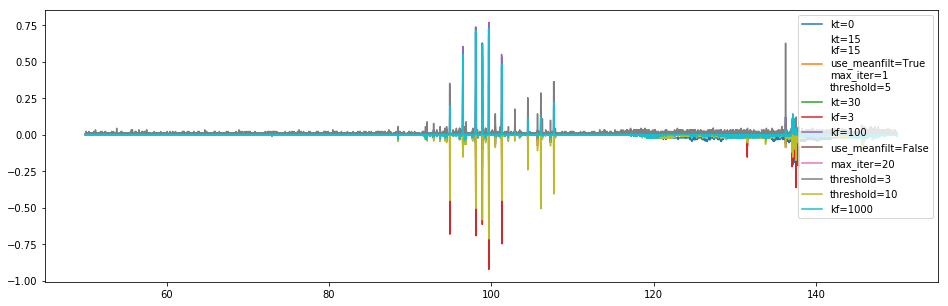

In [130]:
plt.figure(figsize=(16, 5))

fid = np.sum(medfilt_flag_list[1], axis=0)
for i, (fl, inf, opts) in enumerate(zip(medfilt_flag_list, medfilt_info_list, medfilt_options)):
    plt.plot(l1.raw_frequencies, (np.sum(fl, axis=0) -fid)/len(fl), label='\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(medfilt_optnames,opts)) if i==1 or val != medfilt_options[1][j]))
plt.legend();

Minimizing the threshold, and using larger frequency windows seems to pick up more flags (though the wider frequency windows seem to pick up a bit *less* in the areas where there is less RFI, eg. 110-130 MHz). Using different time windows doesn't seem to affect much, nor does iterating.

Now we plot the time (in seconds) that each took to complete:

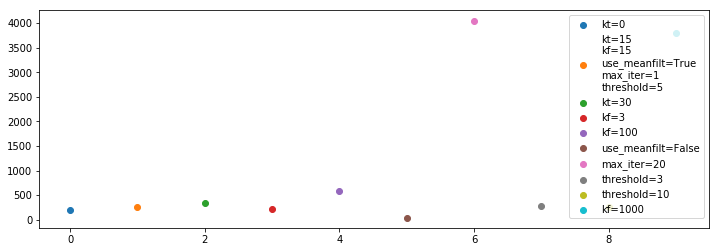

In [131]:
plt.figure(figsize=(12, 4))

for i, (fl, inf, opts, t) in enumerate(zip(medfilt_flag_list, medfilt_info_list, medfilt_options, medfilt_times)):
    plt.scatter(i, t, label='\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(medfilt_optnames,opts)) if i==1 or val != medfilt_options[1][j]))
plt.legend()

As could be expected, iterating takes longer. Also, larger windows take longer (because it's a convolutional window). Overall, these times are prohibitively large (this is a relatively small file with only 91 integrations).

Now we plot the total number of flags for each method:

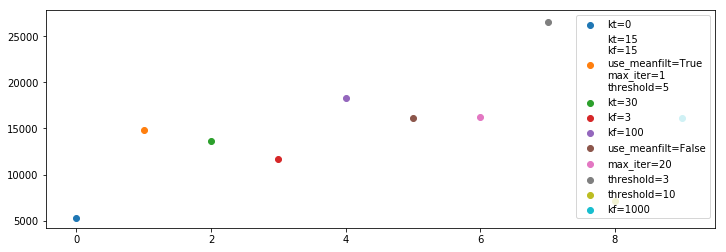

In [132]:
plt.figure(figsize=(12, 4))

for i, (fl, inf, opts, t) in enumerate(zip(medfilt_flag_list, medfilt_info_list, medfilt_options, medfilt_times)):
    plt.scatter(i, np.sum(fl), label='\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(medfilt_optnames,opts)) if i==1 or val != medfilt_options[1][j]))
plt.legend()

The results are much what we had deduced from previous plots.

Overall, the best might be a slightly wider frequency window ($k_f=100$) with the lower threshold of 3. 

Using kt=0 seems to be a bad idea -- we need some of the time information to really get the RMS properly.

### Poly Filter

In [42]:
polyfilt_flag_list = []
polyfilt_info_list = []
polyfilt_times = []

polyfilt_optnames = ['n_signal', 'n_resid', 'increase_order', 'threshold', 'decrement_threshold', 'accumulate']
poly_options = [
    (4, -1, True, 5, 0, False),
    (2, -1, True, 5, 0, False),
    (3, -1, True, 5, 0, False),
    (10, -1, False, 5, 0, False),
    (4, -1, True, 10, 1, False),
    (4, -1, True, 10, 0, False),
    (4, -1, True, 15, 1, False),
    (4, -1, True, 5, 0, True),
    (4, 0, False, 5, 0, False),
    (4, -2, True, 5, 0, False),
]

for opts in poly_options:
    print(f"Computing {opts}...")
    t = time.time()
    flags = np.zeros_like(l1_spectrum, dtype=bool)
    infos = []
    for i, spec in enumerate(l1_spectrum):
        flags[i], info = xrfi.xrfi_poly(
            spectrum=spec,
            **dict(zip(polyfilt_optnames, opts)),
            return_models=True
        )
        infos.append(info)
    # Ensure nothing janky happened to the spectrum
    assert np.all(l1_spectrum == data.spectrum)
    
    
    polyfilt_flag_list.append(flags)
    polyfilt_info_list.append(infos)
    
    polyfilt_times.append(time.time() - t)


Computing (4, -1, True, 5, 0, False)...


/data4/smurray/Projects/radio/EOR/Edges/edges-cal/src/edges_cal/xrfi.py:794: UserWarning: max iterations (20) reached, not all RFI might have been caught.
  f"max iterations ({max_iter}) reached, not all RFI might have been caught."


Computing (2, -1, True, 5, 0, False)...
Computing (3, -1, True, 5, 0, False)...
Computing (10, -1, False, 5, 0, False)...
Computing (4, -1, True, 10, 1, False)...
Computing (4, -1, True, 10, 0, False)...
Computing (4, -1, True, 15, 1, False)...
Computing (4, -1, True, 5, 0, True)...
Computing (4, 0, False, 5, 0, False)...
Computing (4, -2, True, 5, 0, False)...


Again, we first look at the flags in time and frequency:

In [43]:
spec0 = tools.weighted_mean(l1_spectrum, weights=~polyfilt_flag_list[0], axis=0)[0]
mdl = ModelFit('polynomial', data.raw_frequencies, spec0, n_terms=10).evaluate()

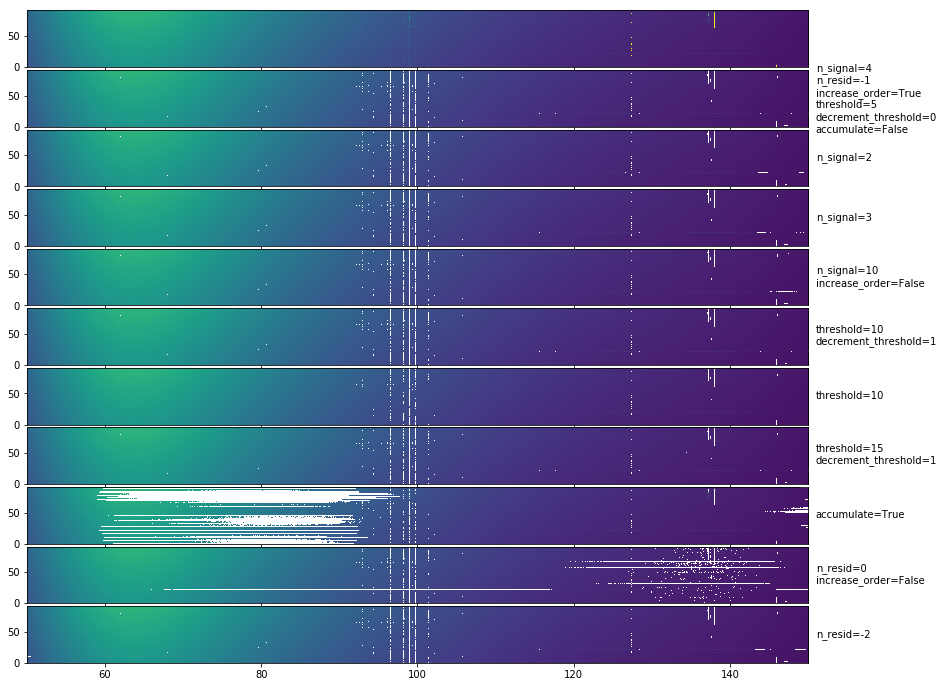

In [44]:
fig, ax = plt.subplots(len(polyfilt_flag_list)+1, 1, sharex=True, sharey=True, figsize=(14, 12), gridspec_kw={'hspace':0.05})
extent=(data.raw_frequencies.min(), data.raw_frequencies.max(), 0, len(l1_spectrum))

ax[0].imshow(data.spectra['Q'], aspect='auto', extent=extent, vmin=0, vmax=4)

for i, (fl, opts) in enumerate(zip(polyfilt_flag_list, poly_options)):
    ax[i+1].imshow(
        np.where(fl, np.nan, data.spectra['Q']), 
        aspect='auto', 
        extent=extent,
        vmin=0, vmax=4
    )
    ax[i+1].text(
        151, 46, 
        '\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(polyfilt_optnames,opts)) if i==0 or val != poly_options[0][j]), 
        ha='left', va='center'
    );

The most obvious outcome here is that setting `accumulate=True` is a bad idea. Other than this, most methods do very similarly. They seem to do pretty well on getting the channel-based RFI, but not so well on the time-based RFI (which makes sense, since they are all independent in time).

Let's have a look at the residual RFI after averaging over times:

In [107]:
tools.weighted_mean??

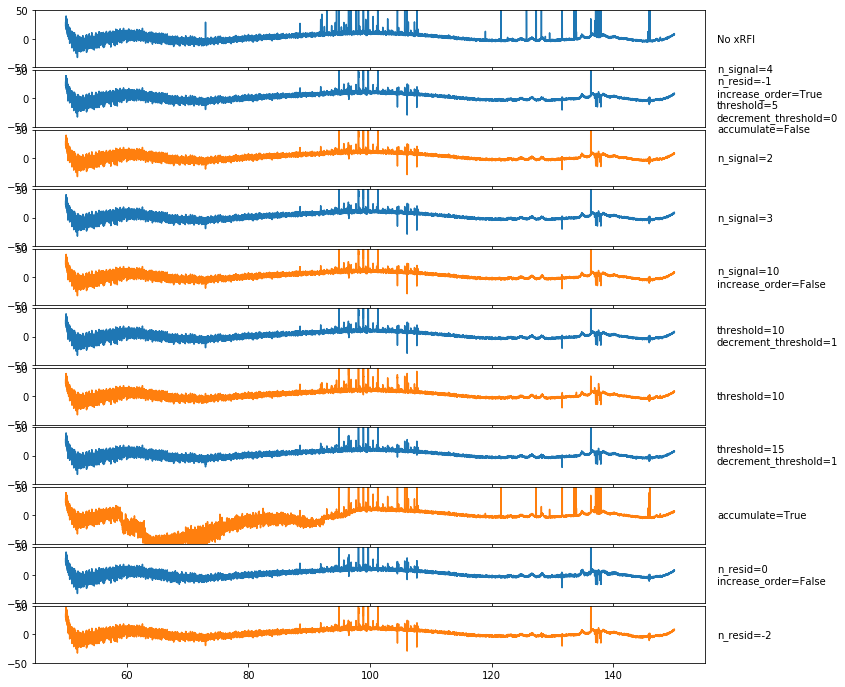

In [108]:
fig, ax = plt.subplots(len(polyfilt_flag_list)+1, 1, sharex=True, sharey=True, figsize=(12, 12), gridspec_kw={"hspace":0.05})

ax[0].plot(data.raw_frequencies, np.mean(l1_spectrum, axis=0)-mdl)
ax[0].text(157, 0, "No xRFI", va='center', ha='left')

for i, (fl, opts) in enumerate(zip(polyfilt_flag_list, poly_options)):
    spec = tools.weighted_mean(l1_spectrum, ~fl, axis=0)[0]
    ax[i+1].plot(data.raw_frequencies, spec - mdl, color=f'C{i%2}')
    ax[i+1].set_ylim(-50, 50)
    ax[i+1].text(157, 0, '\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(polyfilt_optnames,opts)) if i==0 or val != poly_options[0][j]), ha='left', va='center')

Again, there is some trouble with negative RFI peaks, which we'll try to address soon. There is also clearly some channels where at least one integration has missed the RFI, and the average still has the RFI in. It is likely that another round of xRFI directly on the averaged spectra would remove most of the remaining RFI, but we would like to get as much of it as we can in the first step. It is possible that a "watershed" algorithm that targets bins close to those flagged might clear some of this up.

Looking at the flag occupancy per channel, we see that we require a high-order polynomial (at least at the end of the iterations), and that accumulating is not so great. Also, the threshold should be much lower than 10:

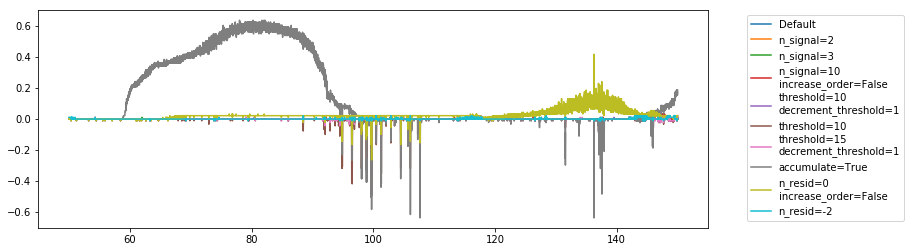

In [49]:
plt.figure(figsize=(12, 4))

fid = np.sum(polyfilt_flag_list[1], axis=0)
for i, (fl, inf, opts) in enumerate(zip(polyfilt_flag_list, polyfilt_info_list, poly_options)):
    plt.plot(data.raw_frequencies, (np.sum(fl, axis=0) -fid)/len(fl), 
             label='Default' if i==0 else '\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(polyfilt_optnames,opts)) if i==0 or val != poly_options[0][j]))
plt.legend(bbox_to_anchor=(1.05, 1));

The timing for the polynomial filter is quite fast -- in the order of 5-10 seconds for 91 integrations (i.e. about an hour's worth of data). That's on the order of 3 minutes for a full day. 

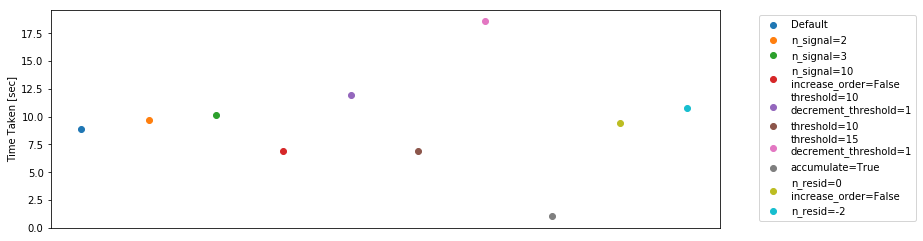

In [52]:
plt.figure(figsize=(12, 4))

for i, (fl, inf, opts, t) in enumerate(zip(polyfilt_flag_list, polyfilt_info_list, poly_options, polyfilt_times)):
    plt.scatter(i, t, label='Default' if i==0 else '\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(polyfilt_optnames,opts)) if i==0 or val != poly_options[0][j]))
plt.legend(bbox_to_anchor=(1.05, 1));
plt.xticks([])
plt.ylabel("Time Taken [sec]");

Looking at the total numbers of flags, we find that they're all pretty similar, except for the two we've identified as bad:

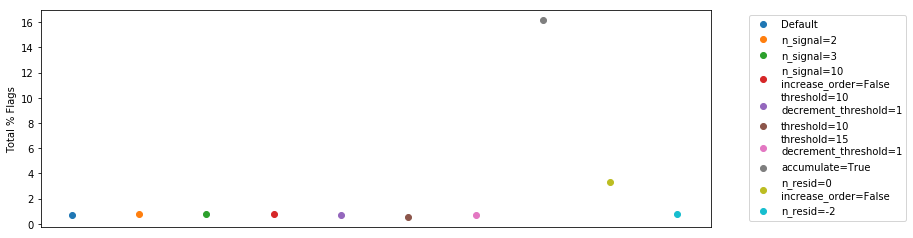

In [54]:
plt.figure(figsize=(12, 4))

for i, (fl, inf, opts, t) in enumerate(zip(polyfilt_flag_list, polyfilt_info_list, poly_options, polyfilt_times)):
    plt.scatter(i, 100*np.sum(fl)/ fl.size, label='Default' if i==0 else '\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(polyfilt_optnames,opts)) if i==0 or val != poly_options[0][j]))
plt.legend(bbox_to_anchor=(1.05, 1));
plt.xticks([])
plt.ylabel("Total % Flags");

Let's have a look at the number of iterations required for each method (for each integration):

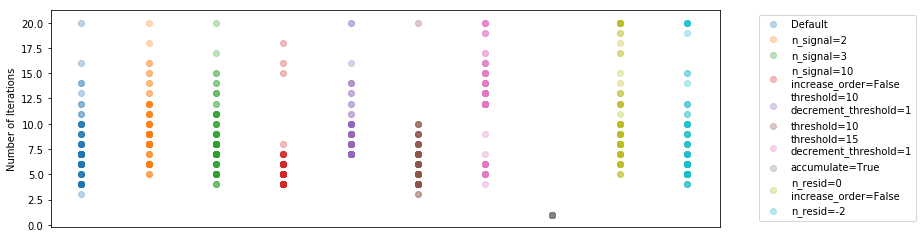

In [57]:
plt.figure(figsize=(12, 4))

for i, (fl, inf, opts, t) in enumerate(zip(polyfilt_flag_list, polyfilt_info_list, poly_options, polyfilt_times)):
    plt.scatter([i]*len(inf), [x['n_iters'] for x in inf], alpha=0.3, label='Default' if i==0 else '\n'.join(f'{name}={val}' for j, (name, val) in enumerate(zip(polyfilt_optnames,opts)) if i==0 or val != poly_options[0][j]))
plt.legend(bbox_to_anchor=(1.05, 1));
plt.xticks([])
plt.ylabel("Number of Iterations");

It's difficult to tell much from this. It seems that using a smaller number of poly terms to begin with means you have to do more iterations on average. Increasing the threshold brings down the number of iterations, as expected.

Now, we choose a single integration from the default method, and look at how its models evolve:

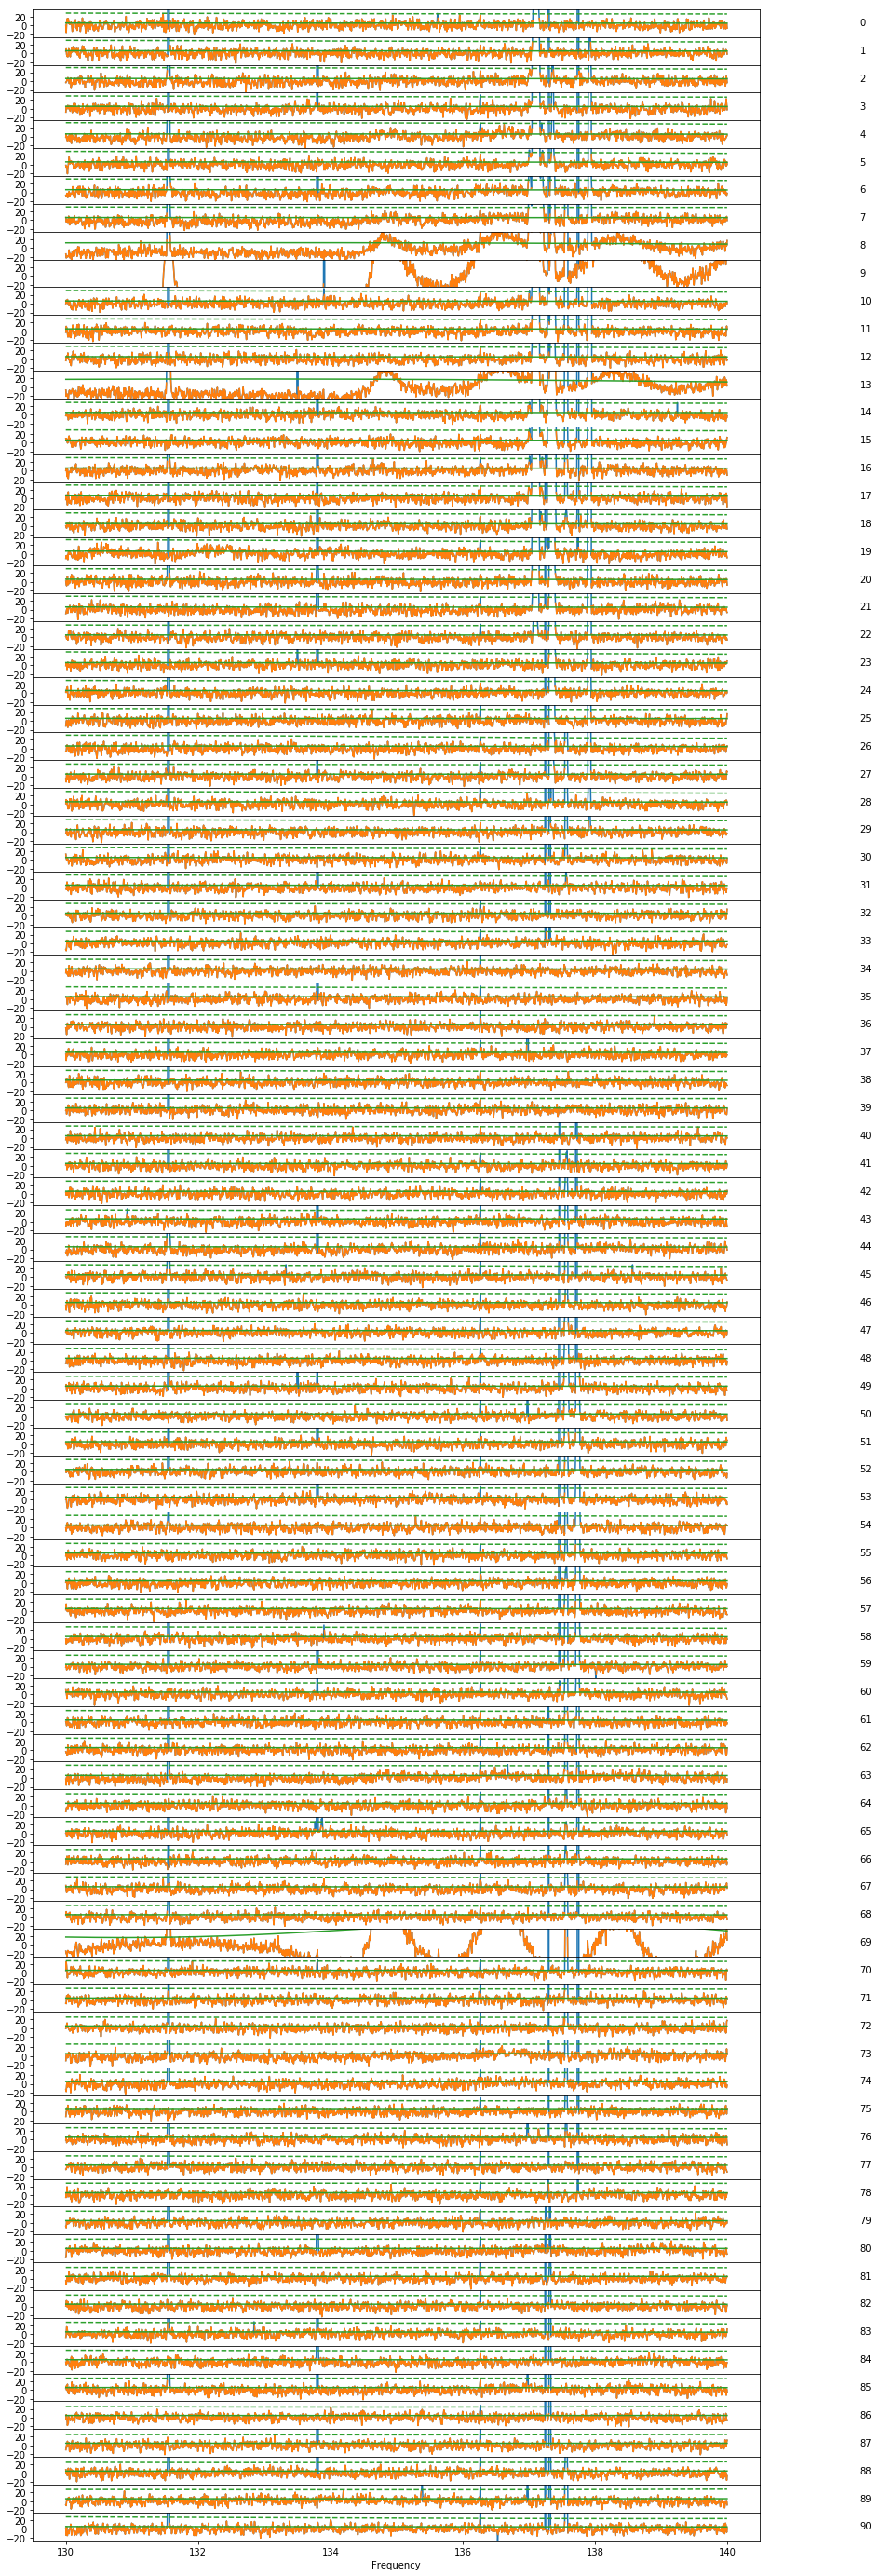

In [84]:
n = 15
mask = (data.raw_frequencies > 130) & (data.raw_frequencies < 140)
fig, ax = plt.subplots(91,1, figsize=(14,50), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
f = np.linspace(-1,1, len(data.raw_frequencies))

for n in range(91):
    single_spec = data.spectrum[n]
    single_info = polyfilt_info_list[0][n]
    single_flags = polyfilt_flag_list[0][n]
    model = np.exp(np.polyval(single_info['models'][-1], f))
    model_std = np.polyval(single_info['model_std'][-1], f)

    ax[n].plot(data.raw_frequencies[mask], (single_spec - model)[mask])
    ax[n].plot(data.raw_frequencies[mask], np.where(single_flags, np.nan, single_spec - model)[mask])
    ax[n].plot(data.raw_frequencies[mask], model_std[mask])
    ax[n].plot(data.raw_frequencies[mask], 5*model_std[mask], color='C2', ls='--')
    ax[n].text(142, 0, str(n))

    ax[n].set_ylim(-26,37)
    ax[n].set_yticks([-20, 0, 20])
    
ax[-1].set_xlabel("Frequency");

It seems like there are a few time integrations that are just hitting some crazy failure mode (8, 9 , 13, 69),  and these are probably contributing most to the bad flags. Let's see:

In [85]:
default_flags = polyfilt_flag_list[0].copy()
default_flags[8] = True
default_flags[9] = True
default_flags[13] = True
default_flags[69] = True

(-50, 50)

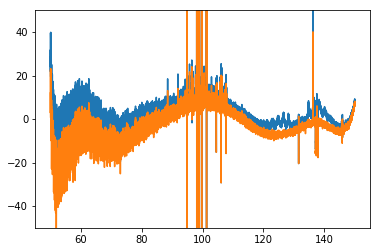

In [91]:
spec = tools.weighted_mean(l1_spectrum, ~default_flags, axis=0)[0]
spec_orig = tools.weighted_mean(l1_spectrum, ~polyfilt_flag_list[0], axis=0)[0]
plt.plot(data.raw_frequencies, spec_orig - mdl)

plt.plot(data.raw_frequencies, spec - mdl)

plt.ylim(-50,50)

No. We have gotten rid of some of the weird oscillations, but not really the RFI. They are probably just lower-level RFI.

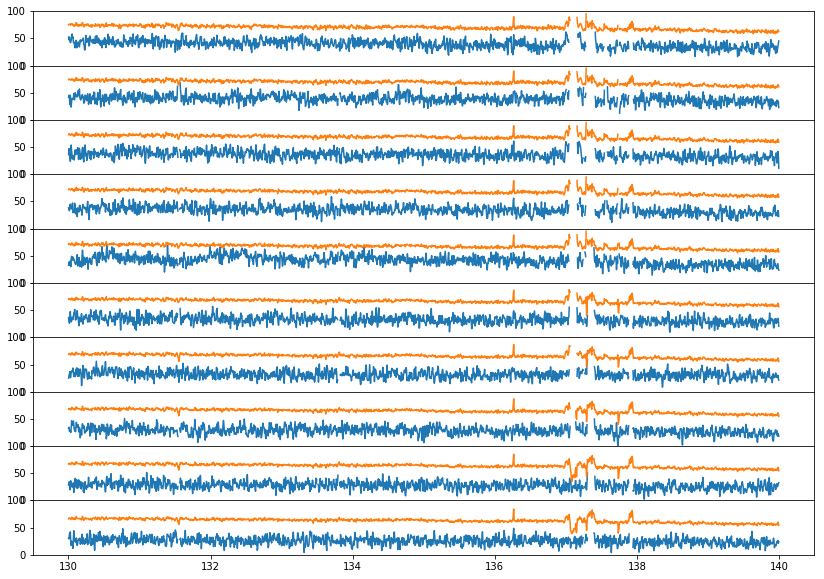

In [129]:
fig, ax = plt.subplots(10, 1, figsize=(14,10), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0.02})

for i in range(15, 25):
    spec = tools.weighted_mean(l1_spectrum[:(i+1)], ~default_flags[:(i+1)], axis=0)[0]
    ax[i-15].plot(data.raw_frequencies[mask], np.where(default_flags[i], np.nan, l1_spectrum[i] - mdl)[mask])
    ax[i-15].plot(data.raw_frequencies[mask], (spec - mdl)[mask]+20)
    
    ax[i-15].set_ylim(0, 100)


What we see here is that the negative RFI spikes are being caused by GHA binning. That is, if a contiguous half of a GHA bin is flagged, then the other half of the bin is going to have a systematically lower or higher temperature. If it is lower, than it will cause negative "RFI" spikes. These should be caught at `Level3`, where xRFI can be run on GHA-averaged data.